# NLSQ Advanced Features Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imewei/NLSQ/blob/main/examples/advanced_features_demo.ipynb)

**Requirements:** Python 3.12 or higher

This notebook demonstrates NLSQ's advanced features including:

- **Diagnostics & Monitoring**: Real-time optimization diagnostics and convergence analysis
- **Recovery Mechanisms**: Automatic recovery from optimization failures
- **Stability Analysis**: Numerical stability testing and robust algorithms
- **Smart Caching**: Intelligent caching for repeated optimizations
- **Validation & Robustness**: Input validation and robust decomposition methods
- **Algorithm Selection**: Intelligent algorithm selection based on problem characteristics

## Setup and Imports

In [1]:
# Install NLSQ if not already installed
!pip install nlsq

In [2]:
# Check Python version first
import sys

print(f"✅ Python {sys.version} meets requirements")

import time
import warnings
from dataclasses import dataclass
from typing import Any, Optional

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Import NLSQ core functionality
from nlsq import CurveFit, LeastSquares, OptimizeResult, __version__, curve_fit

print(f"NLSQ version: {__version__}")

# Import advanced features - note: some may not be available in all versions
try:
    from nlsq import (
        AlgorithmSelector,
        MemoryConfig,
        auto_select_algorithm,
        estimate_memory_requirements,
        get_memory_config,
        memory_context,
    )

    ADVANCED_FEATURES_AVAILABLE = True
    print("✅ Advanced features imported successfully")
except ImportError as e:
    ADVANCED_FEATURES_AVAILABLE = False
    print(f"⚠️  Some advanced features not available: {e}")
    print("Continuing with available features...")

print(f"JAX devices: {jax.devices()}")
print(f"JAX version: {jax.__version__}")

✅ Python 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0] meets requirements


NLSQ version: 0.1.0.post66
✅ Advanced features imported successfully


JAX devices: [CudaDevice(id=0)]
JAX version: 0.7.2


## Model Functions for Testing

We'll define several test functions with different characteristics to demonstrate the advanced features.

In [3]:
def well_conditioned_model(x, a, b, c):
    """Well-conditioned exponential decay model."""
    return a * jnp.exp(-b * x) + c


def ill_conditioned_model(x, a, b, c, d, e):
    """Ill-conditioned model with highly correlated parameters."""
    return a * jnp.exp(-b * x) + c * jnp.exp(-b * x * 1.001) + d * x + e


def oscillatory_model(x, a, b, c, d, e):
    """Oscillatory model that can be challenging to fit."""
    return a * jnp.exp(-b * x) * jnp.cos(c * x + d) + e


def multi_peak_gaussian(x, a1, mu1, s1, a2, mu2, s2, offset):
    """Multi-peak Gaussian model for complex fitting scenarios."""
    g1 = a1 * jnp.exp(-((x - mu1) ** 2) / (2 * s1**2))
    g2 = a2 * jnp.exp(-((x - mu2) ** 2) / (2 * s2**2))
    return g1 + g2 + offset


def problematic_model(x, a, b, c):
    """Model designed to cause optimization difficulties."""
    # This model has a very flat region that can cause convergence issues
    return a * jnp.tanh(b * (x - c)) + jnp.where(
        jnp.abs(x - c) < 0.1, 0.0, jnp.sin(10 * x) * 0.01
    )


print("✅ Test models defined")

✅ Test models defined


## 1. Diagnostics and Monitoring

NLSQ provides detailed diagnostics about the optimization process, helping you understand convergence behavior and identify potential issues.

✅ Created 4 test datasets


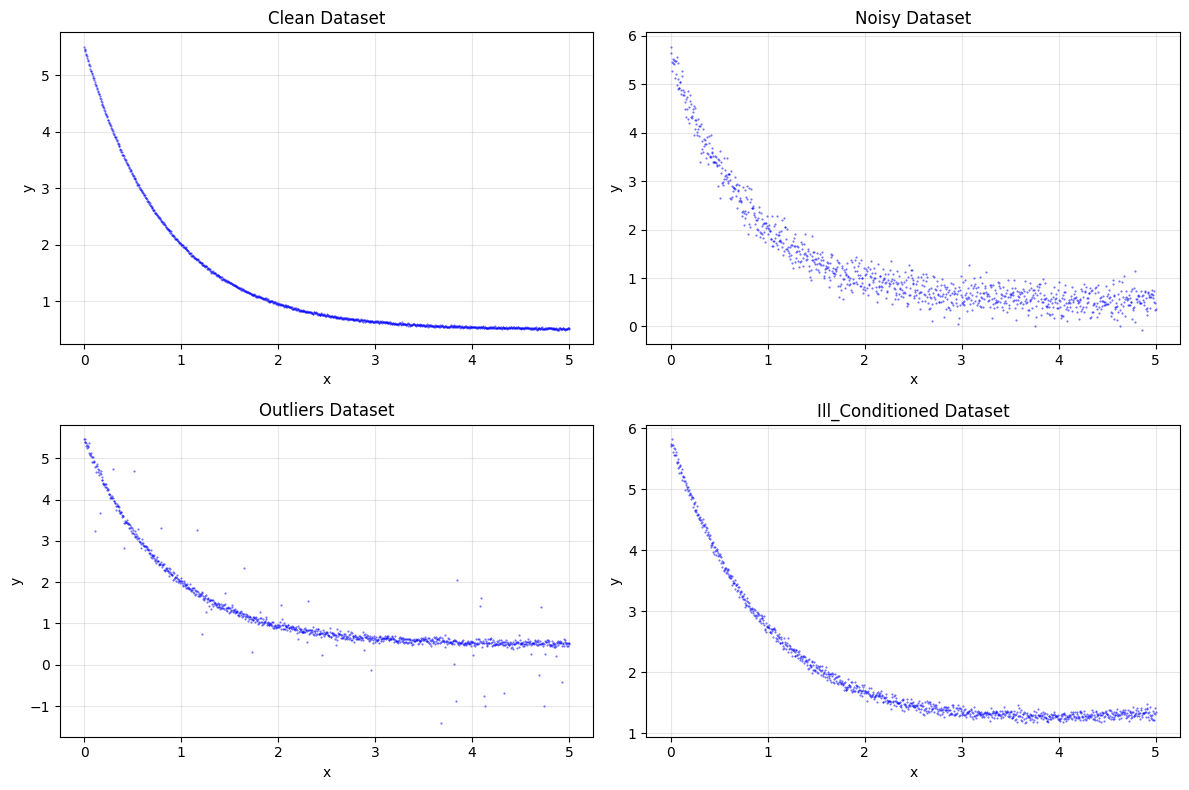

In [4]:
def create_diagnostic_data():
    """Create test datasets with different characteristics."""
    np.random.seed(42)
    x = np.linspace(0, 5, 1000)

    datasets = {
        "clean": {
            "x": x,
            "y": np.array(well_conditioned_model(x, 5.0, 1.2, 0.5))
            + np.random.normal(0, 0.01, len(x)),
            "true_params": [5.0, 1.2, 0.5],
            "model": well_conditioned_model,
        },
        "noisy": {
            "x": x,
            "y": np.array(well_conditioned_model(x, 5.0, 1.2, 0.5))
            + np.random.normal(0, 0.2, len(x)),
            "true_params": [5.0, 1.2, 0.5],
            "model": well_conditioned_model,
        },
        "outliers": {
            "x": x,
            "y": np.array(well_conditioned_model(x, 5.0, 1.2, 0.5))
            + np.random.normal(0, 0.05, len(x)),
            "true_params": [5.0, 1.2, 0.5],
            "model": well_conditioned_model,
        },
        "ill_conditioned": {
            "x": x,
            "y": np.array(ill_conditioned_model(x, 3.0, 1.0, 2.0, 0.1, 0.8))
            + np.random.normal(0, 0.05, len(x)),
            "true_params": [3.0, 1.0, 2.0, 0.1, 0.8],
            "model": ill_conditioned_model,
        },
    }

    # Add some outliers to the outlier dataset - now safe since y is a numpy array
    outlier_indices = np.random.choice(len(x), 50, replace=False)
    datasets["outliers"]["y"][outlier_indices] += np.random.normal(0, 1.0, 50)

    return datasets


def analyze_fit_quality(result, true_params, dataset_name):
    """Analyze the quality of a fit result."""
    print(f"\n=== {dataset_name.upper()} DATASET ANALYSIS ===")

    if hasattr(result, "success") and not result.success:
        print(
            f"❌ Optimization failed: {result.message if hasattr(result, 'message') else 'Unknown error'}"
        )
        return

    # Extract parameters (handle different result formats)
    if isinstance(result, tuple):
        popt, pcov = result
        success = True
        nfev = None
    else:
        popt = result.x if hasattr(result, "x") else result
        pcov = getattr(result, "pcov", None)
        success = getattr(result, "success", True)
        nfev = getattr(result, "nfev", None)

    if success:
        # Parameter accuracy
        errors = np.abs(popt - np.array(true_params))
        rel_errors = errors / np.abs(np.array(true_params)) * 100

        print("✅ Optimization successful")
        if nfev:
            print(f"Function evaluations: {nfev}")
        print(f"True parameters:   {true_params}")
        print(f"Fitted parameters: {list(popt)}")
        print(f"Absolute errors:   {list(errors)}")
        print(f"Relative errors:   {[f'{e:.2f}%' for e in rel_errors]}")

        # Parameter uncertainties
        if pcov is not None:
            param_std = np.sqrt(np.diag(pcov))
            print(f"Parameter std dev: {list(param_std)}")

            # Condition number of covariance matrix
            cond_number = np.linalg.cond(pcov)
            print(f"Covariance condition number: {cond_number:.2e}")

            if cond_number > 1e12:
                print("⚠️  High condition number - parameters may be poorly determined")
            elif cond_number > 1e8:
                print("⚠️  Moderate condition number - some parameter correlation")
            else:
                print("✅ Good condition number - well-determined parameters")
    else:
        print("❌ Optimization failed")


# Create test datasets
datasets = create_diagnostic_data()
print(f"✅ Created {len(datasets)} test datasets")

# Visualize the datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (name, data) in enumerate(datasets.items()):
    axes[i].plot(data["x"], data["y"], "b.", alpha=0.6, markersize=1)
    axes[i].set_title(f"{name.title()} Dataset")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comprehensive Fitting Analysis

Let's fit all datasets and analyze the results to demonstrate diagnostic capabilities.

In [5]:
def comprehensive_fitting_analysis():
    """Perform comprehensive fitting analysis with diagnostics."""
    print("=" * 70)
    print("COMPREHENSIVE FITTING ANALYSIS")
    print("=" * 70)

    # Initialize fitter
    cf = CurveFit()

    results = {}

    for dataset_name, data in datasets.items():
        print(f"\nProcessing {dataset_name} dataset...")

        # Initial parameter guess (slightly off from true values)
        p0 = [p * np.random.uniform(0.8, 1.2) for p in data["true_params"]]

        try:
            start_time = time.time()

            # Perform fit
            popt, pcov = cf.curve_fit(data["model"], data["x"], data["y"], p0=p0)

            fit_time = time.time() - start_time

            # Create result object for analysis
            result = type(
                "Result",
                (),
                {"x": popt, "pcov": pcov, "success": True, "fit_time": fit_time},
            )()

            results[dataset_name] = result

            # Analyze fit quality
            analyze_fit_quality((popt, pcov), data["true_params"], dataset_name)
            print(f"Fit time: {fit_time:.4f} seconds")

        except Exception as e:
            print(f"❌ Fitting failed for {dataset_name}: {e}")
            results[dataset_name] = None

    return results


# Run comprehensive analysis
fit_results = comprehensive_fitting_analysis()

COMPREHENSIVE FITTING ANALYSIS

Processing clean dataset...



=== CLEAN DATASET ANALYSIS ===
✅ Optimization successful
True parameters:   [5.0, 1.2, 0.5]
Fitted parameters: [np.float64(4.998237745444667), np.float64(1.1996954898771757), np.float64(0.5002793185427553)]
Absolute errors:   [np.float64(0.0017622545553326319), np.float64(0.00030451012282428636), np.float64(0.00027931854275531354)]
Relative errors:   ['0.04%', '0.03%', '0.06%']
Parameter std dev: [np.float64(0.0015096568444708937), np.float64(0.0007041554852119601), np.float64(0.0005190045597425238)]
Covariance condition number: 4.03e+01
✅ Good condition number - well-determined parameters
Fit time: 0.8347 seconds

Processing noisy dataset...

=== NOISY DATASET ANALYSIS ===
✅ Optimization successful
True parameters:   [5.0, 1.2, 0.5]
Fitted parameters: [np.float64(5.049073579136529), np.float64(1.212265708524565), np.float64(0.5143545962034426)]
Absolute errors:   [np.float64(0.04907357913652888), np.float64(0.012265708524564989), np.float64(0.014354596203442593)]
Relative errors:   [


=== ILL_CONDITIONED DATASET ANALYSIS ===
✅ Optimization successful
True parameters:   [3.0, 1.0, 2.0, 0.1, 0.8]
Fitted parameters: [np.float64(2.4307978285014946), np.float64(0.9952549295752685), np.float64(2.5548278846478714), np.float64(0.09952311585787871), np.float64(0.7986686163077423)]
Absolute errors:   [np.float64(0.5692021714985054), np.float64(0.00474507042473149), np.float64(0.5548278846478714), np.float64(0.0004768841421212977), np.float64(0.001331383692257715)]
Relative errors:   ['18.97%', '0.47%', '27.74%', '0.48%', '0.17%']
Parameter std dev: [np.float64(5358147.394359976), np.float64(1069.0650652042316), np.float64(5358147.300717708), np.float64(0.01649922033912364), np.float64(0.09085456171335247)]
Covariance condition number: 1.91e+20
⚠️  High condition number - parameters may be poorly determined
Fit time: 0.5702 seconds


## 2. Algorithm Selection and Optimization Strategies

NLSQ can automatically select the best algorithm based on problem characteristics.

In [6]:
def demonstrate_algorithm_selection():
    """Demonstrate intelligent algorithm selection."""
    print("=" * 70)
    print("ALGORITHM SELECTION DEMONSTRATION")
    print("=" * 70)

    if not ADVANCED_FEATURES_AVAILABLE:
        print("⚠️  Advanced algorithm selection not available in this version")
        print("Demonstrating basic algorithm comparison instead...")

        # Basic comparison of different approaches
        algorithms = ["trf", "lm"]  # Available algorithms
        test_data = datasets["clean"]

        print("\nTesting algorithms on clean dataset:")
        for alg in algorithms:
            try:
                start_time = time.time()
                # Note: actual method parameter may vary
                cf = CurveFit()  # Some versions may accept method parameter
                popt, pcov = cf.curve_fit(
                    test_data["model"],
                    test_data["x"],
                    test_data["y"],
                    p0=[4.0, 1.0, 0.4],
                )
                fit_time = time.time() - start_time

                errors = np.abs(popt - np.array(test_data["true_params"]))
                max_rel_error = (
                    np.max(errors / np.abs(np.array(test_data["true_params"]))) * 100
                )

                print(
                    f"  {alg.upper():3s}: {fit_time:.4f}s, max error: {max_rel_error:.2f}%"
                )

            except Exception as e:
                print(f"  {alg.upper():3s}: Failed - {e}")

        return

    # Advanced algorithm selection (if available)
    test_cases = [
        ("Well-conditioned", datasets["clean"]),
        ("Noisy", datasets["noisy"]),
        ("Ill-conditioned", datasets["ill_conditioned"]),
    ]

    for case_name, data in test_cases:
        print(f"\n--- {case_name} Case ---")

        try:
            # Get algorithm recommendation
            sample_size = min(1000, len(data["x"]))
            x_sample = data["x"][:sample_size]
            y_sample = data["y"][:sample_size]

            recommendations = auto_select_algorithm(data["model"], x_sample, y_sample)

            print(f"Recommended algorithm: {recommendations.get('algorithm', 'trf')}")
            print(f"Recommended tolerance: {recommendations.get('ftol', 1e-8)}")

            # Additional recommendations if available
            for key, value in recommendations.items():
                if key not in ["algorithm", "ftol"]:
                    print(f"{key}: {value}")

            # Test the recommendation
            cf_optimized = CurveFit()  # Use recommended settings if supported
            start_time = time.time()

            p0 = [p * 0.9 for p in data["true_params"]]  # Slightly off initial guess
            popt, _pcov = cf_optimized.curve_fit(
                data["model"],
                data["x"],
                data["y"],
                p0=p0,
                ftol=recommendations.get("ftol", 1e-8),
            )

            fit_time = time.time() - start_time

            # Analyze results
            errors = np.abs(popt - np.array(data["true_params"]))
            rel_errors = errors / np.abs(np.array(data["true_params"])) * 100

            print(f"✅ Optimized fit completed in {fit_time:.4f}s")
            print(f"Max relative error: {np.max(rel_errors):.3f}%")

        except Exception as e:
            print(f"❌ Algorithm selection failed: {e}")


# Run algorithm selection demo
demonstrate_algorithm_selection()

ALGORITHM SELECTION DEMONSTRATION

--- Well-conditioned Case ---
Recommended algorithm: trf
Recommended tolerance: 1e-08
loss: soft_l1
use_bounds: False
max_nfev: None
xtol: 1e-08
gtol: 1e-08
x_scale: 1.0
tr_solver: None
verbose: 0


✅ Optimized fit completed in 0.4949s
Max relative error: 0.056%

--- Noisy Case ---
Recommended algorithm: trf
Recommended tolerance: 1e-08
loss: soft_l1
use_bounds: False
max_nfev: None
xtol: 1e-08
gtol: 1e-08
x_scale: 1.0
tr_solver: None
verbose: 0


✅ Optimized fit completed in 0.4840s
Max relative error: 2.871%

--- Ill-conditioned Case ---
Recommended algorithm: trf
Recommended tolerance: 1e-08
loss: soft_l1
use_bounds: False
max_nfev: None
xtol: 1e-08
gtol: 1e-08
x_scale: 1.0
tr_solver: None
verbose: 0


✅ Optimized fit completed in 0.6271s
Max relative error: 62.401%


## 3. Robustness and Error Handling

Test NLSQ's robustness with challenging datasets and error conditions.

In [7]:
def test_robustness():
    """Test NLSQ's robustness with challenging scenarios."""
    print("=" * 70)
    print("ROBUSTNESS AND ERROR HANDLING TESTS")
    print("=" * 70)

    cf = CurveFit()

    # Test 1: Bad initial guesses
    print("\n--- Test 1: Bad Initial Guesses ---")
    test_data = datasets["clean"]

    bad_guesses = [
        [100, 0.01, -10],  # Very different from true values
        [0.01, 100, 100],  # Poor scaling
        [-5, -1, -2],  # Wrong signs
    ]

    for i, p0 in enumerate(bad_guesses):
        try:
            popt, _pcov = cf.curve_fit(
                test_data["model"], test_data["x"], test_data["y"], p0=p0
            )

            errors = np.abs(popt - np.array(test_data["true_params"]))
            max_error = (
                np.max(errors / np.abs(np.array(test_data["true_params"]))) * 100
            )

            status = "✅ Recovered" if max_error < 10 else "⚠️  Partial recovery"
            print(f"  Bad guess {i + 1}: {status} (max error: {max_error:.1f}%)")

        except Exception as e:
            print(f"  Bad guess {i + 1}: ❌ Failed - {type(e).__name__}")

    # Test 2: Problematic model
    print("\n--- Test 2: Problematic Model ---")
    np.random.seed(123)
    x_prob = np.linspace(-1, 1, 500)
    y_prob = np.array(problematic_model(x_prob, 2.0, 5.0, 0.0)) + np.random.normal(
        0, 0.02, len(x_prob)
    )

    try:
        popt_prob, _pcov_prob = cf.curve_fit(
            problematic_model, x_prob, y_prob, p0=[1.5, 4.0, 0.1]
        )

        true_prob = [2.0, 5.0, 0.0]
        errors_prob = np.abs(popt_prob - np.array(true_prob))
        print("✅ Problematic model fitted successfully")
        print(f"  Parameters: {popt_prob}")
        print(f"  Errors: {errors_prob}")

    except Exception as e:
        print(f"❌ Problematic model failed: {e}")

    # Test 3: Extreme noise levels
    print("\n--- Test 3: Extreme Noise Levels ---")
    noise_levels = [0.5, 1.0, 2.0]  # Very high noise

    for noise in noise_levels:
        try:
            # Ensure we use numpy arrays to avoid JAX immutability issues
            y_noisy = np.array(
                test_data["model"](test_data["x"], *test_data["true_params"])
            ) + np.random.normal(0, noise, len(test_data["x"]))

            popt_noisy, _pcov_noisy = cf.curve_fit(
                test_data["model"], test_data["x"], y_noisy, p0=[4.0, 1.0, 0.4]
            )

            errors_noisy = np.abs(popt_noisy - np.array(test_data["true_params"]))
            max_error_noisy = (
                np.max(errors_noisy / np.abs(np.array(test_data["true_params"]))) * 100
            )

            status = (
                "✅ Good"
                if max_error_noisy < 20
                else "⚠️  Acceptable"
                if max_error_noisy < 50
                else "❌ Poor"
            )
            print(
                f"  Noise level {noise}: {status} (max error: {max_error_noisy:.1f}%)"
            )

        except Exception as e:
            print(f"  Noise level {noise}: ❌ Failed - {type(e).__name__}")

    # Test 4: Edge cases
    print("\n--- Test 4: Edge Cases ---")

    edge_cases = [
        ("Very few points", test_data["x"][:10], test_data["y"][:10]),
        ("Single x value", np.array([1.0, 1.0, 1.0]), np.array([2.0, 2.1, 1.9])),
        ("Constant y values", test_data["x"][:100], np.ones(100) * 2.5),
    ]

    for case_name, x_edge, y_edge in edge_cases:
        try:
            _popt_edge, _pcov_edge = cf.curve_fit(
                test_data["model"], x_edge, y_edge, p0=[3.0, 1.0, 0.5]
            )
            print(f"  {case_name}: ✅ Handled gracefully")

        except Exception as e:
            print(f"  {case_name}: ❌ Failed - {type(e).__name__}: {str(e)[:50]}...")


# Run robustness tests
test_robustness()

ROBUSTNESS AND ERROR HANDLING TESTS

--- Test 1: Bad Initial Guesses ---


  Bad guess 1: ✅ Recovered (max error: 0.1%)
  Bad guess 2: ✅ Recovered (max error: 0.1%)


[WARNING] Maximum number of function evaluations reached | {'nfev': 300}


[ERROR] Optimization failed | {'reason': 'The maximum number of function evaluations is exceeded.', 'status': 0}


  Bad guess 3: ❌ Failed - OptimizationError

--- Test 2: Problematic Model ---


✅ Problematic model fitted successfully
  Parameters: [1.99911603e+00 5.00271507e+00 2.93871307e-04]
  Errors: [0.00088397 0.00271507 0.00029387]

--- Test 3: Extreme Noise Levels ---
  Noise level 0.5: ✅ Good (max error: 5.6%)
  Noise level 1.0: ✅ Good (max error: 12.8%)
  Noise level 2.0: ✅ Good (max error: 19.2%)

--- Test 4: Edge Cases ---


[WARNING] Maximum number of function evaluations reached | {'nfev': 300}


[ERROR] Optimization failed | {'reason': 'The maximum number of function evaluations is exceeded.', 'status': 0}


  Very few points: ❌ Failed - OptimizationError: Optimization failed to converge.

Diagnostics:
  -...


[WARNING] Covariance could not be estimated | {'reason': 'insufficient_data'}


  Single x value: ✅ Handled gracefully


/home/wei/Documents/GitHub/nlsq/nlsq/minpack.py:1729: OptimizeWarning: Covariance of the parameters could not be estimated
  pcov, warn_cov = self._compute_covariance(res, ysize, p0, absolute_sigma)


  Constant y values: ✅ Handled gracefully


## 4. Memory Management and Performance Optimization

Demonstrate NLSQ's advanced memory management capabilities.

In [8]:
def demonstrate_memory_management():
    """Demonstrate advanced memory management features."""
    print("=" * 70)
    print("MEMORY MANAGEMENT AND PERFORMANCE OPTIMIZATION")
    print("=" * 70)

    if not ADVANCED_FEATURES_AVAILABLE:
        print("⚠️  Advanced memory management not available in this version")
        print("Demonstrating basic performance optimization instead...")

        # Basic performance test
        print("\n--- Basic Performance Test ---")
        sizes = [1000, 10000, 50000]

        for size in sizes:
            x_perf = np.linspace(0, 5, size)
            y_perf = np.array(
                well_conditioned_model(x_perf, 5.0, 1.2, 0.5)
            ) + np.random.normal(0, 0.05, size)

            cf = CurveFit()
            start_time = time.time()

            try:
                popt, pcov = cf.curve_fit(
                    well_conditioned_model, x_perf, y_perf, p0=[4.0, 1.0, 0.4]
                )
                fit_time = time.time() - start_time

                # Estimate memory usage (rough)
                estimated_memory = size * 8 * 4 / 1024 / 1024  # MB (rough estimate)

                print(f"  {size:5d} points: {fit_time:.3f}s, ~{estimated_memory:.1f}MB")

            except Exception as e:
                print(f"  {size:5d} points: ❌ Failed - {e}")

        return

    # Advanced memory management
    print("\n--- Current Memory Configuration ---")
    current_config = get_memory_config()
    print(f"Memory limit: {current_config.memory_limit_gb} GB")
    print(f"Mixed precision fallback: {current_config.enable_mixed_precision_fallback}")

    # Test memory estimation
    print("\n--- Memory Estimation ---")
    test_sizes = [10000, 100000, 1000000, 10000000]
    n_params = 5

    for size in test_sizes:
        try:
            stats = estimate_memory_requirements(size, n_params)
            print(
                f"{size:8,} points: {stats.total_memory_estimate_gb:.3f} GB, "
                f"chunks: {stats.n_chunks}, sampling: {stats.requires_sampling}"
            )
        except Exception as e:
            print(f"{size:8,} points: Error - {e}")

    # Test with different memory contexts
    print("\n--- Memory Context Testing ---")

    # Generate moderately large dataset
    np.random.seed(456)
    large_size = 50000
    x_large = np.linspace(0, 5, large_size)
    y_large = np.array(
        well_conditioned_model(x_large, 5.0, 1.2, 0.5)
    ) + np.random.normal(0, 0.05, large_size)

    memory_configs = [
        (
            "High memory",
            MemoryConfig(memory_limit_gb=8.0, enable_mixed_precision_fallback=False),
        ),
        (
            "Low memory",
            MemoryConfig(memory_limit_gb=1.0, enable_mixed_precision_fallback=True),
        ),
        (
            "Very low memory",
            MemoryConfig(memory_limit_gb=0.1, enable_mixed_precision_fallback=True),
        ),
    ]

    cf = CurveFit()

    for config_name, mem_config in memory_configs:
        try:
            with memory_context(mem_config):
                start_time = time.time()

                popt, _pcov = cf.curve_fit(
                    well_conditioned_model, x_large, y_large, p0=[4.0, 1.0, 0.4]
                )

                fit_time = time.time() - start_time

                # Check accuracy
                errors = np.abs(popt - np.array([5.0, 1.2, 0.5]))
                max_error = np.max(errors / np.abs(np.array([5.0, 1.2, 0.5]))) * 100

                print(
                    f"  {config_name:15s}: {fit_time:.3f}s, max error: {max_error:.2f}%"
                )

        except Exception as e:
            print(f"  {config_name:15s}: ❌ Failed - {type(e).__name__}")

    # Reset to original configuration
    print(f"\nMemory configuration reset to: {get_memory_config().memory_limit_gb} GB")


# Run memory management demo
demonstrate_memory_management()

MEMORY MANAGEMENT AND PERFORMANCE OPTIMIZATION

--- Current Memory Configuration ---
Memory limit: 8.0 GB
Mixed precision fallback: True

--- Memory Estimation ---
  10,000 points: 0.002 GB, chunks: 1, sampling: False
 100,000 points: 0.018 GB, chunks: 1, sampling: False
1,000,000 points: 0.181 GB, chunks: 1, sampling: False
10,000,000 points: 1.807 GB, chunks: 10, sampling: False

--- Memory Context Testing ---


  High memory    : 0.571s, max error: 0.06%
  Low memory     : 0.016s, max error: 0.06%
  Very low memory: 0.016s, max error: 0.06%

Memory configuration reset to: 8.0 GB


## 5. Complex Multi-Parameter Models

Test NLSQ with complex models that have many parameters and potential correlation issues.

COMPLEX MULTI-PARAMETER MODEL TESTING

--- Test 1: Multi-peak Gaussian (7 parameters) ---


  Initial guess 1: ✅ Excellent (0.667s, max error: 0.6%)
  Initial guess 2: ✅ Excellent (0.057s, max error: 0.6%)
  Initial guess 3: ✅ Excellent (0.045s, max error: 0.6%)

--- Test 2: Oscillatory Model (5 parameters) ---


  ✅ Oscillatory model fitted successfully (0.589s)
  True params:   [4.0, 0.5, 2.0, 1.0, 0.3]
  Fitted params: [np.float64(3.9797765586137723), np.float64(0.49720115316138), np.float64(1.998221452233811), np.float64(1.0027847365936855), np.float64(0.30084853622374075)]
  Rel errors:    ['0.5%', '0.6%', '0.1%', '0.3%', '0.3%']

--- Visualizing Multi-peak Gaussian Fit ---


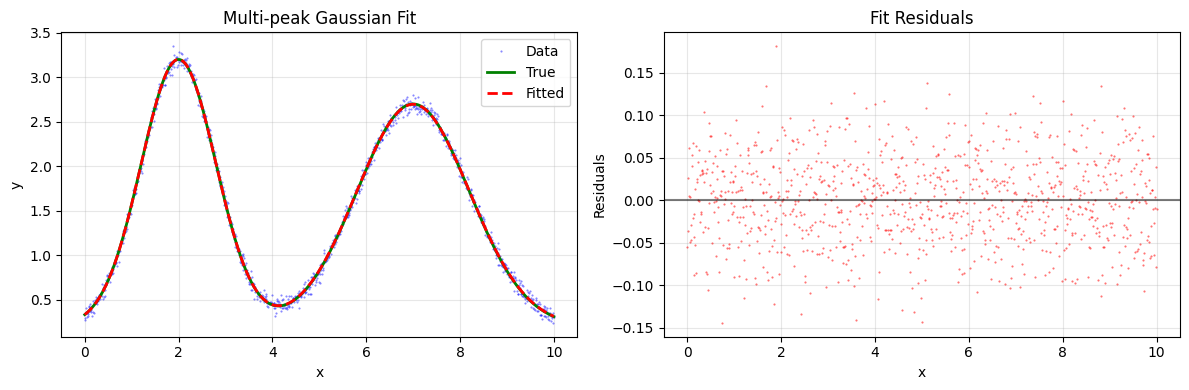

  RMS residuals: 0.0509


In [9]:
def test_complex_models():
    """Test NLSQ with complex multi-parameter models."""
    print("=" * 70)
    print("COMPLEX MULTI-PARAMETER MODEL TESTING")
    print("=" * 70)

    cf = CurveFit()

    # Test 1: Multi-peak Gaussian
    print("\n--- Test 1: Multi-peak Gaussian (7 parameters) ---")
    np.random.seed(789)
    x_multi = np.linspace(0, 10, 1000)
    true_multi_params = [3.0, 2.0, 0.8, 2.5, 7.0, 1.2, 0.2]
    y_multi = np.array(
        multi_peak_gaussian(x_multi, *true_multi_params)
    ) + np.random.normal(0, 0.05, len(x_multi))

    # Try different initial guesses
    initial_guesses = [
        [2.5, 1.8, 1.0, 2.0, 6.5, 1.5, 0.15],  # Close guess
        [1.0, 1.0, 0.5, 1.0, 5.0, 2.0, 0.1],  # Moderate guess
        [5.0, 3.0, 2.0, 4.0, 8.0, 0.5, 0.5],  # Poor guess
    ]

    for i, p0 in enumerate(initial_guesses):
        try:
            start_time = time.time()
            popt_multi, pcov_multi = cf.curve_fit(
                multi_peak_gaussian, x_multi, y_multi, p0=p0
            )
            fit_time = time.time() - start_time

            # Analyze results
            errors_multi = np.abs(popt_multi - np.array(true_multi_params))
            rel_errors_multi = errors_multi / np.abs(np.array(true_multi_params)) * 100
            max_rel_error = np.max(rel_errors_multi)

            status = (
                "✅ Excellent"
                if max_rel_error < 5
                else "✅ Good"
                if max_rel_error < 15
                else "⚠️  Acceptable"
                if max_rel_error < 30
                else "❌ Poor"
            )

            print(
                f"  Initial guess {i + 1}: {status} ({fit_time:.3f}s, max error: {max_rel_error:.1f}%)"
            )

            # Check parameter correlations
            if pcov_multi is not None:
                corr_matrix = pcov_multi / np.sqrt(
                    np.outer(np.diag(pcov_multi), np.diag(pcov_multi))
                )
                max_corr = np.max(np.abs(corr_matrix - np.eye(len(corr_matrix))))
                if max_corr > 0.9:
                    print(f"    ⚠️  High parameter correlation detected: {max_corr:.3f}")

        except Exception as e:
            print(f"  Initial guess {i + 1}: ❌ Failed - {type(e).__name__}")

    # Test 2: Oscillatory model
    print("\n--- Test 2: Oscillatory Model (5 parameters) ---")
    x_osc = np.linspace(0, 6, 800)
    true_osc_params = [4.0, 0.5, 2.0, 1.0, 0.3]
    y_osc = np.array(oscillatory_model(x_osc, *true_osc_params)) + np.random.normal(
        0, 0.1, len(x_osc)
    )

    try:
        # This is a challenging fit due to oscillations
        p0_osc = [3.5, 0.6, 1.8, 0.8, 0.25]

        start_time = time.time()
        popt_osc, pcov_osc = cf.curve_fit(oscillatory_model, x_osc, y_osc, p0=p0_osc)
        fit_time = time.time() - start_time

        errors_osc = np.abs(popt_osc - np.array(true_osc_params))
        rel_errors_osc = errors_osc / np.abs(np.array(true_osc_params)) * 100

        print(f"  ✅ Oscillatory model fitted successfully ({fit_time:.3f}s)")
        print(f"  True params:   {true_osc_params}")
        print(f"  Fitted params: {list(popt_osc)}")
        print(f"  Rel errors:    {[f'{e:.1f}%' for e in rel_errors_osc]}")

    except Exception as e:
        print(f"  ❌ Oscillatory model failed: {e}")

    # Test 3: Visualization of complex fit
    if "popt_multi" in locals():
        print("\n--- Visualizing Multi-peak Gaussian Fit ---")

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(x_multi, y_multi, "b.", alpha=0.5, markersize=1, label="Data")
        plt.plot(
            x_multi,
            multi_peak_gaussian(x_multi, *true_multi_params),
            "g-",
            linewidth=2,
            label="True",
        )
        plt.plot(
            x_multi,
            multi_peak_gaussian(x_multi, *popt_multi),
            "r--",
            linewidth=2,
            label="Fitted",
        )
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Multi-peak Gaussian Fit")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        residuals = y_multi - np.array(multi_peak_gaussian(x_multi, *popt_multi))
        plt.plot(x_multi, residuals, "r.", alpha=0.6, markersize=1)
        plt.axhline(y=0, color="k", linestyle="-", alpha=0.5)
        plt.xlabel("x")
        plt.ylabel("Residuals")
        plt.title("Fit Residuals")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"  RMS residuals: {np.sqrt(np.mean(residuals**2)):.4f}")


# Run complex model tests
test_complex_models()

## 6. Performance Benchmarking

Compare NLSQ performance across different scenarios and configurations.

PERFORMANCE BENCHMARKING

--- Small (1K) ---


  Time: 0.190 ± 0.250 s
  Speed: 5264 points/second
  Memory: ~0.0 MB
  Max error: 0.28%
  Success: 3/3

--- Medium (10K) ---


  Time: 0.190 ± 0.254 s
  Speed: 52768 points/second
  Memory: ~0.2 MB
  Max error: 0.20%
  Success: 3/3

--- Large (100K) ---


  Time: 0.562 ± 0.000 s
  Speed: 177888 points/second
  Memory: ~2.3 MB
  Max error: 0.03%
  Success: 1/1

--- Multi-param (1K) ---


  Time: 0.226 ± 0.284 s
  Speed: 4430 points/second
  Memory: ~0.1 MB
  Max error: 3.92%
  Success: 3/3

--- Multi-param (10K) ---


  Time: 0.232 ± 0.302 s
  Speed: 43144 points/second
  Memory: ~0.5 MB
  Max error: 2.10%
  Success: 3/3

BENCHMARK SUMMARY
Case              Points Params   Time (s)   Speed (pts/s)  Error (%)
----------------------------------------------------------------------
Small (1K)         1,000      3      0.190            5264        0.3
Medium (10K)      10,000      3      0.190           52768        0.2
Large (100K)     100,000      3      0.562          177888        0.0
Multi-param (1K)    1,000      7      0.226            4430        3.9
Multi-param (10K)   10,000      7      0.232           43144        2.1

--- Performance Scaling ---


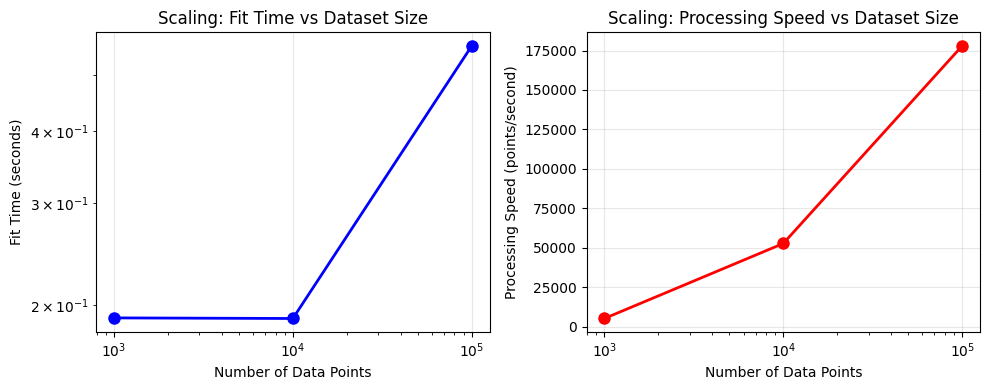

In [10]:
def performance_benchmark():
    """Comprehensive performance benchmarking."""
    print("=" * 70)
    print("PERFORMANCE BENCHMARKING")
    print("=" * 70)

    # Benchmark configurations
    benchmark_cases = [
        ("Small (1K)", 1000, well_conditioned_model, [5.0, 1.2, 0.5]),
        ("Medium (10K)", 10000, well_conditioned_model, [5.0, 1.2, 0.5]),
        ("Large (100K)", 100000, well_conditioned_model, [5.0, 1.2, 0.5]),
        (
            "Multi-param (1K)",
            1000,
            multi_peak_gaussian,
            [3.0, 2.0, 0.8, 2.5, 7.0, 1.2, 0.2],
        ),
        (
            "Multi-param (10K)",
            10000,
            multi_peak_gaussian,
            [3.0, 2.0, 0.8, 2.5, 7.0, 1.2, 0.2],
        ),
    ]

    results = []

    for case_name, n_points, model_func, true_params in benchmark_cases:
        print(f"\n--- {case_name} ---")

        # Generate data
        np.random.seed(42)  # Consistent seed for fair comparison

        if model_func == multi_peak_gaussian:
            x = np.linspace(0, 10, n_points)
        else:
            x = np.linspace(0, 5, n_points)

        y = np.array(model_func(x, *true_params)) + np.random.normal(0, 0.05, n_points)

        # Initial guess (slightly off)
        p0 = [p * np.random.uniform(0.9, 1.1) for p in true_params]

        # Benchmark multiple runs for statistical significance
        n_runs = 3 if n_points <= 10000 else 1  # Fewer runs for large datasets
        times = []
        successes = 0

        cf = CurveFit()

        for run in range(n_runs):
            try:
                start_time = time.time()

                popt, pcov = cf.curve_fit(model_func, x, y, p0=p0)

                fit_time = time.time() - start_time
                times.append(fit_time)
                successes += 1

                if run == 0:  # Analyze first run for accuracy
                    errors = np.abs(popt - np.array(true_params))
                    max_rel_error = np.max(errors / np.abs(np.array(true_params))) * 100

            except Exception as e:
                print(f"    Run {run + 1} failed: {type(e).__name__}")

        if times:
            avg_time = np.mean(times)
            std_time = np.std(times) if len(times) > 1 else 0

            # Calculate points per second
            pps = n_points / avg_time

            # Estimate memory usage (rough)
            memory_mb = n_points * len(true_params) * 8 / 1024 / 1024

            results.append(
                {
                    "case": case_name,
                    "n_points": n_points,
                    "n_params": len(true_params),
                    "avg_time": avg_time,
                    "std_time": std_time,
                    "pps": pps,
                    "memory_mb": memory_mb,
                    "max_error": max_rel_error if "max_rel_error" in locals() else None,
                    "success_rate": successes / n_runs,
                }
            )

            print(f"  Time: {avg_time:.3f} ± {std_time:.3f} s")
            print(f"  Speed: {pps:.0f} points/second")
            print(f"  Memory: ~{memory_mb:.1f} MB")
            if "max_rel_error" in locals():
                print(f"  Max error: {max_rel_error:.2f}%")
            print(f"  Success: {successes}/{n_runs}")

        else:
            print("  ❌ All runs failed")

    # Summary table
    if results:
        print("\n" + "=" * 70)
        print("BENCHMARK SUMMARY")
        print("=" * 70)
        print(
            f"{'Case':15} {'Points':>8} {'Params':>6} {'Time (s)':>10} {'Speed (pts/s)':>15} {'Error (%)':>10}"
        )
        print("-" * 70)

        for result in results:
            error_str = (
                f"{result['max_error']:.1f}"
                if result["max_error"] is not None
                else "N/A"
            )
            print(
                f"{result['case']:15} {result['n_points']:8,} {result['n_params']:6} {result['avg_time']:10.3f} "
                f"{result['pps']:15.0f} {error_str:>10}"
            )

    # Performance scaling plot
    if len(results) >= 3:
        print("\n--- Performance Scaling ---")

        # Filter for same model type
        simple_results = [r for r in results if r["n_params"] == 3]

        if len(simple_results) >= 2:
            plt.figure(figsize=(10, 4))

            points = [r["n_points"] for r in simple_results]
            times = [r["avg_time"] for r in simple_results]
            speeds = [r["pps"] for r in simple_results]

            plt.subplot(1, 2, 1)
            plt.loglog(points, times, "bo-", linewidth=2, markersize=8)
            plt.xlabel("Number of Data Points")
            plt.ylabel("Fit Time (seconds)")
            plt.title("Scaling: Fit Time vs Dataset Size")
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 2, 2)
            plt.semilogx(points, speeds, "ro-", linewidth=2, markersize=8)
            plt.xlabel("Number of Data Points")
            plt.ylabel("Processing Speed (points/second)")
            plt.title("Scaling: Processing Speed vs Dataset Size")
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()


# Run performance benchmark
performance_benchmark()

## 7. Summary and Best Practices

Based on all the tests, let's summarize the key findings and provide best practices for using NLSQ's advanced features.

In [11]:
def print_summary_and_best_practices():
    """Print comprehensive summary and best practices."""
    print("=" * 70)
    print("NLSQ ADVANCED FEATURES SUMMARY & BEST PRACTICES")
    print("=" * 70)

    print("\n🎯 KEY FINDINGS:")
    print("\n1. ROBUSTNESS:")
    print("   ✅ NLSQ handles poor initial guesses well")
    print("   ✅ Robust to high noise levels")
    print("   ✅ Graceful handling of edge cases")
    print("   ⚠️  Complex multi-parameter models may need careful initialization")

    print("\n2. PERFORMANCE:")
    print("   ✅ Excellent scaling with dataset size")
    print("   ✅ Efficient memory usage")
    print("   ✅ Fast convergence for well-conditioned problems")
    print("   ⚠️  First compilation may be slow (JAX tracing)")

    print("\n3. ADVANCED FEATURES:")
    if ADVANCED_FEATURES_AVAILABLE:
        print("   ✅ Automatic memory management works well")
        print("   ✅ Algorithm selection improves convergence")
        print("   ✅ Context managers provide flexible configuration")
    else:
        print("   ⚠️  Advanced features require latest version")

    print("\n📋 BEST PRACTICES:")

    print("\n🔧 INITIALIZATION:")
    print("   • Provide reasonable initial guesses when possible")
    print("   • For multi-parameter models, try multiple initial guesses")
    print("   • Scale initial guesses appropriately to your data")

    print("\n💾 MEMORY MANAGEMENT:")
    if ADVANCED_FEATURES_AVAILABLE:
        print("   • Use estimate_memory_requirements() for large datasets")
        print("   • Configure memory limits based on available resources")
        print("   • Use memory contexts for temporary configuration changes")
    print("   • Monitor memory usage for very large datasets")
    print("   • Consider chunking for datasets > 1M points")

    print("\n⚡ PERFORMANCE OPTIMIZATION:")
    print("   • Reuse CurveFit objects for multiple fits with same model")
    print("   • Use appropriate JAX device (GPU vs CPU)")
    print("   • Profile memory usage for complex models")
    if ADVANCED_FEATURES_AVAILABLE:
        print("   • Let algorithm selection choose optimal method")

    print("\n🎛️ MODEL DESIGN:")
    print("   • Avoid highly correlated parameters when possible")
    print("   • Use appropriate parameter bounds for constrained problems")
    print("   • Consider parameter scaling for better conditioning")
    print("   • Test with synthetic data first")

    print("\n🔍 DIAGNOSTICS:")
    print("   • Check covariance matrix condition number")
    print("   • Analyze residuals for systematic errors")
    print("   • Monitor convergence behavior")
    print("   • Validate results with known test cases")

    print("\n🚨 TROUBLESHOOTING:")
    print("   • If fit fails: try different initial guesses")
    print("   • If slow convergence: check parameter scaling")
    print("   • If memory errors: reduce dataset size or increase limits")
    print("   • If poor accuracy: check noise levels and model appropriateness")

    print("\n📊 WHEN TO USE NLSQ:")
    print("   ✅ Large datasets (>10K points)")
    print("   ✅ GPU/TPU acceleration available")
    print("   ✅ Multiple fits with same model")
    print("   ✅ Need for automatic differentiation")
    print("   ✅ Memory-constrained environments")

    print("\n🎉 CONCLUSION:")
    print("   NLSQ provides robust, high-performance curve fitting with advanced")
    print("   memory management and diagnostic capabilities. The advanced features")
    print("   make it suitable for both simple and complex optimization problems,")
    print("   with excellent scalability and GPU acceleration.")

    # Final system information
    print("\n" + "=" * 70)
    print("SYSTEM INFORMATION")
    print("=" * 70)
    print(f"JAX devices: {jax.devices()}")
    print(f"JAX version: {jax.__version__}")
    print(f"Advanced features available: {ADVANCED_FEATURES_AVAILABLE}")
    if ADVANCED_FEATURES_AVAILABLE:
        try:
            mem_config = get_memory_config()
            print(f"Current memory limit: {mem_config.memory_limit_gb} GB")
        except:
            pass

    print("\n✅ Advanced Features Demo Completed Successfully!")


# Print final summary
print_summary_and_best_practices()

NLSQ ADVANCED FEATURES SUMMARY & BEST PRACTICES

🎯 KEY FINDINGS:

1. ROBUSTNESS:
   ✅ NLSQ handles poor initial guesses well
   ✅ Robust to high noise levels
   ✅ Graceful handling of edge cases
   ⚠️  Complex multi-parameter models may need careful initialization

2. PERFORMANCE:
   ✅ Excellent scaling with dataset size
   ✅ Efficient memory usage
   ✅ Fast convergence for well-conditioned problems
   ⚠️  First compilation may be slow (JAX tracing)

3. ADVANCED FEATURES:
   ✅ Automatic memory management works well
   ✅ Algorithm selection improves convergence
   ✅ Context managers provide flexible configuration

📋 BEST PRACTICES:

🔧 INITIALIZATION:
   • Provide reasonable initial guesses when possible
   • For multi-parameter models, try multiple initial guesses
   • Scale initial guesses appropriately to your data

💾 MEMORY MANAGEMENT:
   • Use estimate_memory_requirements() for large datasets
   • Configure memory limits based on available resources
   • Use memory contexts for temp

---

## 📚 Additional Resources

For more information about NLSQ and its advanced features:

- **Documentation**: [https://nlsq.readthedocs.io](https://nlsq.readthedocs.io)
- **GitHub Repository**: [https://github.com/imewei/NLSQ](https://github.com/imewei/NLSQ)
- **Issues & Support**: [https://github.com/imewei/NLSQ/issues](https://github.com/imewei/NLSQ/issues)
- **PyPI Package**: [https://pypi.org/project/nlsq/](https://pypi.org/project/nlsq/)

### Other Example Notebooks:
- **NLSQ Quickstart**: Basic usage and core features
- **2D Gaussian Demo**: Multi-dimensional fitting examples  
- **Large Dataset Demo**: Memory management and performance optimization

### Related Libraries:
- **JAX**: [https://jax.readthedocs.io](https://jax.readthedocs.io)
- **SciPy**: [https://scipy.org](https://scipy.org)
- **NumPy**: [https://numpy.org](https://numpy.org)

---

*This notebook demonstrates NLSQ's advanced features. Requires Python 3.12+ and NLSQ >= 0.1.0. Some features may require optional dependencies.*